<a href="https://colab.research.google.com/github/eduardodpms/cis_trainee_rns/blob/main/CIS_Trainee_RNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Trainee CIS (3° Período) - Redes Neurais***

Informações do *Trainee*:

- **Nome**: Eduardo de Pina Moreira Santos
- **Matrícula**: 231034494
- **Curso**: Engenharia de Software (FCTE)
- **E-mail**: eduardopms19@hotmail.com
- **Telefone**: (62)9 9994-1250

## **1. Introdução**

Este trabalho corresponde à atividade do 3° período do *Trainee* do capítulo estudantil da [*Computational Intelligence Society*](https://cis.ieee.org) do *IEEE*, na [Universidade de Brasília](https://www.unb.br). Demais informações do *Trainee* estão disponíveis no [*GitHub*](https://github.com/UnB-CIS/Trainee/tree/main). O foco dessa atividade é a elaboração de um modelo de Rede Neural, utilizando bibliotecas do [*Python*](https://www.python.org) como [*Pandas*](https://pandas.pydata.org), [*Matplotlib*](https://matplotlib.org), [*seaborn*](https://seaborn.pydata.org), [*scikit-learn*](https://scikit-learn.org), [*TensorFlow*](https://www.tensorflow.org) e [*NumPy*](https://numpy.org). O *Dataset* de treino é o [*Stellar Classification Dataset - SDSS17*](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17), disponível no [*Kaggle*](https://www.kaggle.com).

O *Dataset* traz 100.000 tuplas e 17 atributos relacionados a características de imagens de objetos estelares, como **Estrelas**, **Galáxias** e **Quasares**. O objetivo da atividade é o desenvolvimento e otimização de um modelo de Rede Neural de classificação, a fim de testar as habilidades do aluno no que tange à análise de dados e de *features* e à abordagem desse modelo.

## **2. Disposição do *Dataset***

### 2.1. Importação de Bibliotecas e Definição de Classes

In [ ]:
# Importação das bibliotecas necessárias

import pandas as pd # Manipulação de arquivos
import matplotlib.pyplot as plt # Geração de figuras
import matplotlib.colors # Manipulação de cores
import seaborn as sns # Visualização estatística
import numpy as np # Manipulação de arrays

from sklearn.preprocessing import LabelEncoder, StandardScaler # Pré-Processamento de dados
from sklearn.model_selection import train_test_split # Separação dos conjuntos de Treino, Validação e Teste

In [ ]:
# Classe para visualização de métricas referentes aos atributos do DataSet
class DataView():
  # Método de inicialização da classe
  def __init__(self, df, show_dim, categoricals, sequence, highlight_cols, inclusions):
    self.df = df # DataFrame a ser analisado
    self.show_dim = show_dim # Exibição das dimensões do DataFrame
    self.categoricals = categoricals # Inclusão de colunas categóricas
    self.sequence = sequence # Sequência de ordenação das colunas
    self.highlight_cols = highlight_cols # Colunas numéricas a destacar com gradiente
    self.inclusions = inclusions # Dicionário com métricas a incluir na visualização
    self.num_cols = self.df.select_dtypes(include='number').columns # Colunas numéricas do DataFrame

  # Método para definição das métricas desejadas
  def metrics(self):
    stats = pd.DataFrame(index=self.inclusions.keys(), columns=self.df.columns) # Cria um Dataframe vazio, com as mesmas características do original

    for col in stats.columns:
      stats.loc[['data_type', 'mode'], col] = [self.df[col].dtype, self.df[col].mode().iloc[0]] # Atribui o tipo dos dados e a moda
      stats.loc[['null_count', 'n_unique'], col] = [self.df[col].isnull().sum(), self.df[col].nunique()] # Atribui a contagem de Null e de valores únicos

      if col in self.num_cols: # Caso as variáveis sejam numéricas
        stats.loc[['type', 'zero_count'], col] = ['Numerical', (self.df[col] == 0).sum()] # Atribui o tipo do atributo e a contagem de zeros
        stats.loc[['mean', 'std', 'min', 'max'], col] = [self.df[col].mean(), self.df[col].std(), self.df[col].min(), self.df[col].max()] # Atribui média, desvio-padrão, min e máx
        stats.loc[['q1', 'median', 'q3'], col] = [self.df[col].quantile(0.25), self.df[col].median(), self.df[col].quantile(0.75)] # Atribui os quartis 1, 2 e 3

        iqr = stats.loc['q3', col] - stats.loc['q1', col] # Calcula o índice iqr com base nos quartis
        stats.loc['outliers_low', col] = (self.df[col] < (stats.loc['q1', col] - 1.5 * iqr)).sum() # Atribui a contagem de outliers menores que o primeiro quartil
        stats.loc['outliers_high', col] = (self.df[col] > (stats.loc['q3', col] + 1.5 * iqr)).sum() # Atribui a contagem de outliers maiores que o segund quartil
        stats.loc['outliers_total', col] = stats.loc['outliers_low', col] + stats.loc['outliers_high', col] # Atribui a contagem total de outliers

      else: # Caso as variáveis sejam categóricas
        stats.loc['type', col] = 'Categorical' # Define a string que caracteriza o tipo
        stats.loc[['zero_count', 'mean', 'std', 'min', 'max', 'q1', 'median', 'q3'], col] = np.nan # Define os dados numéricos como NaN

    included_metrics = [key for key, value in self.inclusions.items() if value] # Lista de atributos a retornar
    included_atributes = stats.columns if self.categoricals else self.num_cols

    if self.sequence[0] in self.inclusions.keys(): # Verifica se a key de ordenação é válida
      included_atributes = sorted(included_atributes, key=lambda x: stats.loc[self.sequence[0], x], reverse=self.sequence[1]) # Ordena os atributos
    elif self.sequence[0] != 'default': # Verifica se a key de ordenação é inválida e diferente de "default"
      print(f"\nWARNING: Invalid sorting atribute. Using default sorting.\n") # Exibe um warning e não ordena os atributos

    return stats.loc[included_metrics, included_atributes].T # Retorna o DataFrame com as métricas e ordenação desejadas

  # Método para visualização das métricas desejadas em forma de tabela
  def show(self):
    stats = self.metrics() # Gera as métricas

    if self.show_dim: # Caso a exibição de dimensões tenha sido habilitada
      print(f"Dimensions: {self.df.shape[0]} rows X {self.df.shape[1]} columns") # Exibe as dimensões do DataFrame

    for col in self.highlight_cols: # Loop para evitar erros durante a seleção de highlights com gradiente
      if (col not in stats.columns) or (col in ['type', 'data_type', 'mode']): # Se não foi selecionada ou não é numérica
        return print(f"\nWARNING: Invalid highlighted metrics selection ('{col}').\n\n{stats}") # Gera um warning e exibe uma tabela simplificada

    # Retorna o Styler com formatação e gradiente visual
    return stats.style\
      .background_gradient(cmap='YlGnBu', subset=self.highlight_cols)\
      .format(na_rep='-', precision=2)\
      .set_caption("DataFrame's Atributes Metrics")

A classe *DataView* é um modelo personalizado de exibição de métricas referentes ao *DataFrame*. Em uma mesma tabela, ela relaciona métricas como média, desvio padrão, quartis e contagem de outliers com cada atributo do *Dataset*, além de permitir a inclusão de atributos categóricos na exibição. Seu objetivo é aprofundar a investigação de maneira simples, porém rica.

### 2.2. Importação e Investigação do *Dataset*

In [ ]:
# Importação e visualização do dataset
data_raw = pd.read_csv(filepath_or_buffer='star_classification.csv') # Tranfere o conjunto de dados para um Dataframe, com o auxílio da biblioteca Pandas

print(f'{data_raw.to_string(max_rows=18, show_dimensions=True)}') # Apresenta as n primeiras e n últimas linhas da relação

             obj_ID       alpha      delta         u         g         r         i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID   class  redshift  plate    MJD  fiber_ID
0      1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371    3606       301        2        79  6.543777e+18  GALAXY  0.634794   5812  56354       171
1      1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427    4518       301        5       119  1.176014e+19  GALAXY  0.779136  10445  58158       427
2      1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827    3606       301        2       120  5.152200e+18  GALAXY  0.644195   4576  55592       299
3      1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454  19.25010    4192       301        3       214  1.030107e+19  GALAXY  0.932346   9149  58039       775
4      1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.497

Uma análise rápida da prévia da relação, com a utilização do método `to_string` permite inferir os seguintes itens:

- A relação é composta por **100.000 tuplas** (0-99999) e por **18 atributos**;
- O *Dataset* contém apenas atributos numéricos (*int* ou *float*), sendo a única excessão a classe de *outcome*;
- Alguns atributos, como obj_ID e spec_obj_ID, apresentam uma grande desproporcionalidade de escala em relação a outros;
- Muitos atributos são referentes a *ID's* de identificação. Por isso, não serão relevantes para a análise.

Em seguida, é importante observar a distribuição de elementos para cada classe de *outcome*:

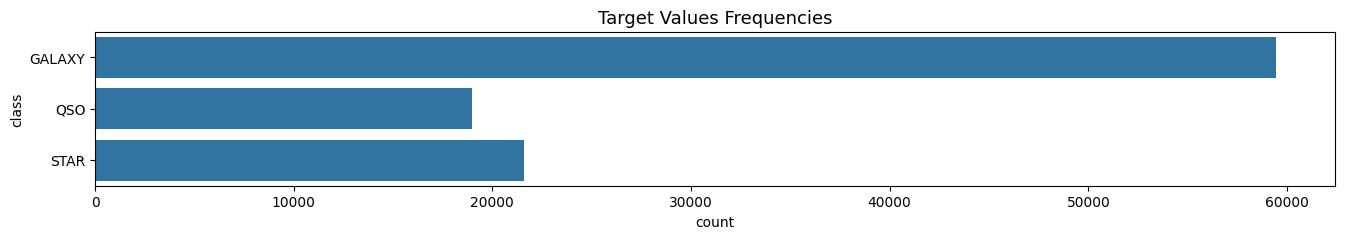

In [ ]:
# Exibe a contagem de cada valor do Target no Dataset
plt.figure(figsize=(16, 2))
sns.countplot(data_raw["class"])
plt.title("Target Values Frequencies",fontsize=13)
plt.show()

É perceptível que o *dataset* possui uma grande desproporcionalidade no que tange à quantidade de elementos da classe `GALAXY`.

Seguindo adiante, utiliza-se da classe *DataView* para extrair métricas relevantes de cada atributo:

In [ ]:
# Criação do objeto para visualização das métricas
data_view = DataView(df=data_raw, # Atribuição do DataFrame contendo o DataSet
                     show_dim = True, # Exibição das dimensões do DataFrame
                     categoricals = True, # Inclusão de colunas categóricas
                     sequence = ('type', True), # Sequência de ordenação das colunas
                     highlight_cols = ['outliers_total'], # Colunas *numéricas* a destacar com gradiente
                     inclusions = {'type': True, 'data_type': True, 'null_count': True, 'zero_count': True, # Dicionário com as métricas desejadas
                                 'mean': True, 'std': True, 'min': True, 'max': True,
                                 'q1': True, 'median': True, 'q3': True, 'n_unique': True, 'mode': True,
                                 'outliers_low': False, 'outliers_high': False, 'outliers_total': True,})

data_view.show() # Plota a tabela com o método "show"

Dimensions: 100000 rows X 18 columns


,type,data_type,null_count,zero_count,mean,std,min,max,q1,median,q3,n_unique,mode,outliers_total
obj_ID,Numerical,float64,0,0,1237664721814903296.00,8438559894562.68,1237645942904389888.00,1237680531356386304.00,1237659161195119360.00,1237663463144292864.00,1237668350286447104.00,78053,1237659326031000064.00,0
alpha,Numerical,float64,0,0,177.63,96.50,0.01,360.00,127.52,180.90,233.90,99999,34.75,0
delta,Numerical,float64,0,0,24.14,19.64,-18.79,83.00,5.15,23.65,39.90,99999,-0.60,0
u,Numerical,float64,0,0,21.98,31.77,-9999.00,32.78,20.35,22.18,23.69,93748,24.63,56
g,Numerical,float64,0,0,20.53,31.75,-9999.00,31.60,18.97,21.10,22.12,92651,25.11,99
r,Numerical,float64,0,0,19.65,1.85,9.82,29.57,18.14,20.13,21.04,91901,24.80,132
i,Numerical,float64,0,0,19.08,1.76,9.47,32.14,17.73,19.41,20.40,92019,24.36,198
z,Numerical,float64,0,0,18.67,31.73,-9999.00,29.38,17.46,19.00,19.92,92007,22.83,320
run_ID,Numerical,int64,0,0,4481.37,1964.76,109,8162,3187.00,4188.00,5326.00,430,3699,0
rerun_ID,Numerical,int64,0,0,301.00,0.00,301,301,301.00,301.00,301.00,1,301,0


Com a interpretação das métricas apresentadas, surgem algumas observações:

- Os atributos `u`, `g` e `z` parecem apresentar dados incorretos, como o seu valor mínimo;
- Os atributos `field_ID` e `redshift` apresentam uma quantidade alta de *outliers*;
- O atributo `rerun_ID` possui valor constante em todas as tuplas;
- O *Dataset* é dotado de diversos atributos relacionados a *ID* de identificação ou data, que não trazem correlação com os elementos visuais do conjunto. São eles: `obj_ID`, `run_ID`, `rerun_ID`, `field_ID`, `spec_obj_ID`, `fiber_ID`, `plate` e `MJD`.

### 2.3. Ajuste e Tratamento do *Dataset*

Após uma etapa de investigação superficial, foi relatada a necessidade de um tratamento do *Dataset*.

In [ ]:
data = data_raw.copy(deep = True) # Salvando o Dataframe que sofrerá tratamento em "data"

Primeiramente, remove-se os atributos de identificação, os quais não trazem correlação com os dados visuais e, portanto, não impactarão positivamente no treinamento da rede, conforme abordado anteriormente. Isso pode trazer certo efeito positivo no tempo de treinamento.

In [ ]:
data.drop(columns=["obj_ID", "run_ID", # Remove as colunas desnecessárias
                   "rerun_ID","field_ID",
                   "spec_obj_ID", "fiber_ID",
                   "plate", "MJD"],
          inplace=True)

num_cols = data.select_dtypes(include=['number']) # Separa os atributos numéricos em "num_cols"

O segundo passo de tratamento do modelo corresponde à normalização dos atributos. A normalização é um processo que redefine as escalas das variáveis, de forma que variem dentro de um mesmo intervalo (com *μ* = 0 e *σ* = 1), sem afetar possíveis relações entre os dados. Isso garante que a diferença entre a escala dos atributos não traga prejuízos para os cálculos executados pelo modelo.

In [ ]:
# Normalização dos dados numéricos
scaler = StandardScaler() # Instancia o normalizador
data_scaled = scaler.fit_transform(num_cols) # Normaliza os dados numéricos em "num_data_scaled"
data_scaled = pd.DataFrame(data_scaled, columns=num_cols.columns) # Cria um DataFrame com os dados normalizados

Posteriormente, utiliza-se da técnica de *encoding*, ou *codificação*, para transformar as *strings* do *outcome* em valores numéricos, sem hierarquia. Esse processo é fundamental, uma ves que modelos de Rede Neural processam apenas valores numéricos.

In [ ]:
# Codificação do atributo categórico ("class")
le = LabelEncoder() # Cria o objeto de codificação
data_scaled['class'] = le.fit_transform(data['class']) # Aplica a codificação no atributo "class"
pd.DataFrame({'Class': le.classes_, 'Encoding': range(len(le.classes_))}).style.hide(axis="index") # Gera uma tabela para a relação

Class,Encoding
GALAXY,0
QSO,1
STAR,2


Por fim, é importante analisar os *boxplots* dos atributos de interesse, a fim de identificar possíveis incongruências:

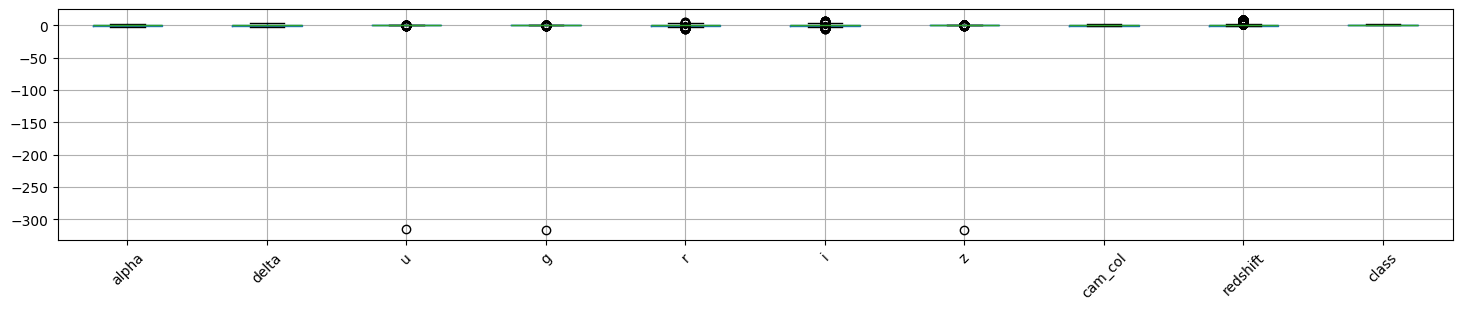

In [ ]:
# Plotando os boxplots com matplotlib
plt.figure(figsize=(18, 3))
data_scaled.boxplot()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Após interpretação dos *boxplots*, conforme suposto anteriormente, os atributos `u`, `g` e `z` apresentam *outliers* singulares marcantes, que distorcem toda a visualização dos elementos gráficos. Assim, uma imputação pela média é perfeitamente válida aqui:

In [ ]:
# Ajusta os outliers discrepantes
for col in ['u', 'g', 'z']:
  data_scaled.loc[data_scaled[col] < -300, col] = data_scaled[col].mean()

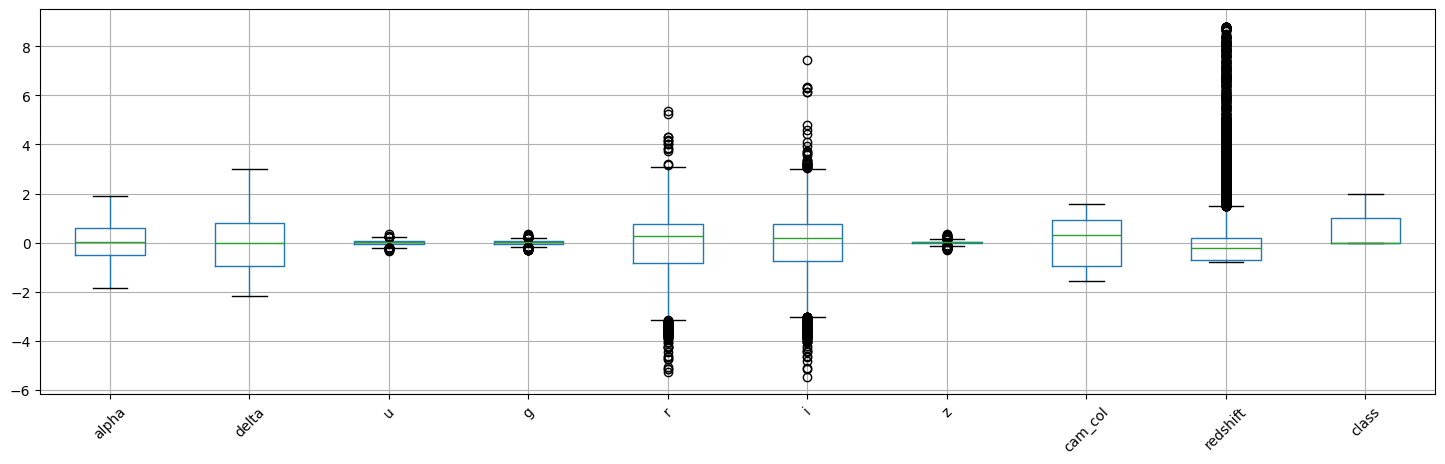

In [ ]:
# Plotando os boxplots com matplotlib
plt.figure(figsize=(18, 5))
data_scaled.boxplot()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Após a correção dos dados para visualização dos *boxplots*, e análise dos mesmos, conclui-se que os atributos, com excessão de `redshift`, parecem seguir uma distribuição verossímil. Assim, com o devido tratamento do *Dataset*, ele está pronto para o *split*.

### 2.4. Divisão dos Conjuntos

Aqui, o *Dataset* tratado será dividido de acordo com os conjuntos necessários para o desenvolvimento da análise.

Inicialmente, define-se as proporcões dos conjuntos de teste e de validação e o valor de `random_state`:

In [ ]:
test_size = 0.2 # Proporção de dados de teste em relação ao tamanho do dataset
val_size = 0.2 # Proporção de dados de validação em relação ao tamanho do dataset
random_state = 42 # Como o modelo aleatorizará o dataset

Depois, separa-se os *features* (dados de entrada) em `x` e os *targets* (*labels* ou dados de saída) em `y`:

In [ ]:
# Separando features e target
x = data_scaled.drop('class', axis=1) # Features
y = data_scaled['class'] # Target

Por fim, separa-se tanto os *features* quanto o *target* nos seguintes conjuntos:
- **Train** (**Treinamento**): conjunto utilizado para definir os pesos do modelo;
- **Validation** (**Validação**): conjunto utilizado para validar cada época durante o treino;
- **Test** (**Teste**): conjunto utilizado para avaliar o modelo final e fazer predições;

In [ ]:
# Separando os conjuntos de Treino, Validação e Teste
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=test_size, stratify=y, random_state=random_state)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=(val_size/(1-test_size)), stratify=y_temp, random_state=random_state)

# Visualizando os tamanhos bruto e relativo de cada conjunto
pd.DataFrame({'Set': ['Train', 'Validation', 'Test', 'Total'],
              'Set Size': [len(x_train), len(x_val), len(x_test), len(data_scaled)],
              'Set Ratio': [len(x_train)/len(data_scaled), len(x_val)/len(data_scaled),
                            len(x_test)/len(data_scaled), len(data_scaled)/len(data_scaled)]
              }).style \
                .background_gradient(cmap='Blues').set_caption("Split Summary") \
                .hide(axis="index").format({'Set Ratio': '{:.1%}', 'Set Size': '{:,}'})

Set,Set Size,Set Ratio
Train,"60,000",60.0%
Validation,"20,000",20.0%
Test,"20,000",20.0%
Total,"100,000",100.0%


## **3. Elaboração da *Rede Neural***

### 3.1. Importação de Bibliotecas e Definição de Classes

In [ ]:
# Importação de bibliotecas relacionadas ao modelo
from tensorflow.keras import Sequential # Modelo sequencial
from tensorflow.keras.layers import Dense # Camadas
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, LossScaleOptimizer # Otimizadores
from tensorflow.keras.regularizers import l1, l2, l1_l2 # Regularizadores L1 e L2
from sklearn.metrics import classification_report # Métricas de avaliação

In [ ]:
# Definição do modelo sequencial do Keras
class seq():
  # Inicialização da classe
  def __init__(self, x_train, y_train, x_val, y_val):
    self.x_train, self.y_train = x_train, y_train # Conjuntos de treino
    self.x_val, self.y_val = x_val, y_val # Conjuntos de validação

  # Construção do modelo
  def build(self, layer_sizes, activations, regularizer):
    model = Sequential() # Cria o objeto do modelo
    for units, act in zip(layer_sizes, activations): # Loop para criação das camadas
      model.add(Dense(units, activation=act, kernel_regularizer=regularizer)) # Adiciona cada camada com o n° de neurônios especificado

    model.add(Dense(3, activation='softmax')) # Camada de saída com softmax
    self.model = model # Salva o modelo

  # Compilação do modelo
  def compile(self, optimizer, loss, lr):
    self.model.compile(optimizer=optimizer(learning_rate=lr), # Compilação com o otimizador definido
                       loss=loss, metrics=['accuracy']) # Função de perda e métrica utilizada

  # Treinamento do modelo
  def fit(self, epochs, batch_size, verbose=1):
    history = self.model.fit(self.x_train, self.y_train, # Conjuntos de treino
                             validation_data=(self.x_val, self.y_val), # Conjuntos de validação
                             epochs=epochs, batch_size=batch_size, # Número de épocas e tamanho dos batches
                             verbose=verbose) # Detalhamento das informações durante o treino
    return history # Retorna as informações de treino

A classe referente ao modelo sequencial, representando a Rede Neural que será utilizada, pode ser dividida da seguinte maneira:
- **Inicialização:** Importa os conjuntos de treino e validação;
- **Construção:** Cria a arquitetura do modelo, com base nos parâmetros passados;
- **Compilação:** Compila o modelo construído, também com base nos parâmetros;
- **Treinamento:** Treina o modelo, efetua a validação e retorna o histórico.

### 3.2. Treinamento do Modelo

A princípio, é importante avaliar o modelo construído com valores padrões comumente utilizados em seus parâmetros. No tópico [*4. Testes com Variação de Parâmetros*](), serão testados os possíveis efeitos de variações destes na Rede Neural.

In [ ]:
# Inicializa o modelo com os conjuntos definidos
model = seq(x_train, y_train, x_val, y_val)

# Cria o modelo com os parâmetros definidos
model.build(layer_sizes = (64, 32), # Largura e profundidade da rede
            activations = ('relu', 'relu'), # Funções de Ativação para cada camada
            regularizer = None) # Regularizador

# Compila o modelo com os parâmetros definidos
model.compile(optimizer = Adam, # Otimizador
              loss = 'sparse_categorical_crossentropy', # Função de Perda
              lr = 0.001) # Learning Rate ou Taxa de Aprendizado

# Treina o modelo com os parâmetros definidos
history = model.fit(epochs = 15, # Número de épocas
                    batch_size = 128) # Tamanho dos batches

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7688 - loss: 0.5797 - val_accuracy: 0.9412 - val_loss: 0.2035
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9413 - loss: 0.1929 - val_accuracy: 0.9561 - val_loss: 0.1538
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9527 - loss: 0.1605 - val_accuracy: 0.9633 - val_loss: 0.1330
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9600 - loss: 0.1408 - val_accuracy: 0.9582 - val_loss: 0.1291
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9608 - loss: 0.1335 - val_accuracy: 0.9622 - val_loss: 0.1208
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9613 - loss: 0.1311 - val_accuracy: 0.9659 - val_loss: 0.1140
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9634 - loss: 0.1229 - val_accuracy: 0.9646 - val_loss: 0.1147
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9627 - loss: 0.1243 - val_accuracy: 0

### 3.3. Avaliação do Modelo

In [ ]:
# Predição do modelo com base no conjunto de teste
y_pred = model.model.predict(x_test) # Executa a predição do modelo
y_pred_classes = y_pred.argmax(axis=1) # Converte as probabilidades para rótulos

# Visualização das métricas de avaliação
print(classification_report(y_test, y_pred_classes, digits=4,
                            target_names=['Estrela', 'Galáxia', 'Quasar']))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

     Estrela     0.9722    0.9768    0.9745     11889
     Galáxia     0.9654    0.9127    0.9383      3792
      Quasar     0.9655    0.9993    0.9821      4319

    accuracy                         0.9695     20000
   macro avg     0.9677    0.9629    0.9650     20000
weighted avg     0.9695    0.9695    0.9693     20000



Após treinamento, validação e avaliação do modelo, é perceptível que o modelo já apresentou uma acurácia satisfatória para o conjunto de dados apresentado, utilizando parâmetros "padrões". Agora, prossegue-se para a execução de testes com variações nos mesmos.

## **4. Testes com Variação de Parâmetros**

Nesse tópico, serão executadas múltiplas instâncias de treinamento do modelo desenvolvido com mudanças em parâmetros específicos, a fim de testar o efeito delas na acurácia de validação para o *Dataset* trabalhado. Os parâmetros que a serem testados são:
- *Learning Rate* (**Tópico 4.2.**);
- *Função de Ativação* (**Tópico 4.3.**);
- *Largura e Profundidade* (**Tópico 4.4.**);
- *Otimizador* (**Tópico 4.5.**);
- *Regurarizador* (**Tópico 4.6.**);
- *Número de Épocas* (**Tópico 4.7.**).

### 4.1. Definições Gerais

Aqui, é definida uma função para a execução "rápida" e resumida de um modelo com os parâmetros definidos.

Além disso, é definida também uma função para a visualização da comparação de **Acurácia de Validação** X **Época** para cada modelo.

In [ ]:
# Função para a execução de múltiplos modelos
def explore(layer_sizes=(64, 32), activations=('relu', 'relu'),
            regularizer=None, optimizer=Adam,
            loss='sparse_categorical_crossentropy',
            learning_rate=0.001, epochs=15, batch_size=128):

  model = seq(x_train, y_train, x_val, y_val) # Inicializa o modelo
  model.build(layer_sizes, activations, regularizer) # Atribui os parâmetros ao modelo
  model.compile(optimizer, loss, learning_rate) # Compila o modelo
  return model.fit(epochs, batch_size, 0) # Treina o modelo e retorna as informações de treino


# Função para a visualização da comparação de modelos
def view(parameter, histories):
  plt.figure(figsize=(10, 4)) # Define o tamanho do subplot

  # Adiciona os valores de acurácia x época de cada modelo
  for value, val_acc in histories.items():
      plt.plot(range(1, len(val_acc) + 1), val_acc, label=f"{parameter} = {value}")

  # Plota um gráfico de Acurácia de Validação X Época
  plt.title("val_accuracy per epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Val Accuracy")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

Depois, são definidos os dicionários e listas contendo os valores de cada parâmetro que se deseja aplicar para efeito de comparação:

In [ ]:
# Definição de conjuntos de valores para testes comparativos

# Valores de teste para Learning Rate
lr_classes = [1e-4, 5e-4, 1e-3, 5e-3]

# Funções de Ativação para teste
act_classes = [('relu', 'relu'),
               ('relu', 'sigmoid'),
               ('tanh', 'relu'),
               ('tanh', 'sigmoid'),
               ('tanh', 'tanh')]

# Valores de teste para Largura e Profundidade da rede
layer_classes = [[(64,), ('relu',)],
                 [(64, 32), ('relu', 'relu')],
                 [(128, 64), ('relu', 'relu')],
                 [(128, 64, 32), ('relu', 'relu', 'relu')],
                 [(256, 128, 64), ('relu', 'relu', 'relu')]]

# Otimizadores para teste
opt_classes = {'adam': Adam,
               'sgd': SGD,
               'rmsprop': RMSprop,
               'adagrad': Adagrad}

# Regularizadores para teste
reg_classes = {'no_reg': None,
               'l1': l1,
               'l2': l2,
               'l1_l2': l1_l2}

### 4.2. Variação do *Learning Rate*

O *Learning Rate* é a taxa que determina o tamanho do ajuste dos pesos por meio do gradiente em cada época durante o processo de treinamento. Para essa comparação, por padrão, estão sendo testados os valores:

- `1e-4` ou `0.0001`;
- `5e-4` ou `0.0005`;
- `1e-3` ou `0.001`;
- `5e-3` ou `0.005`.

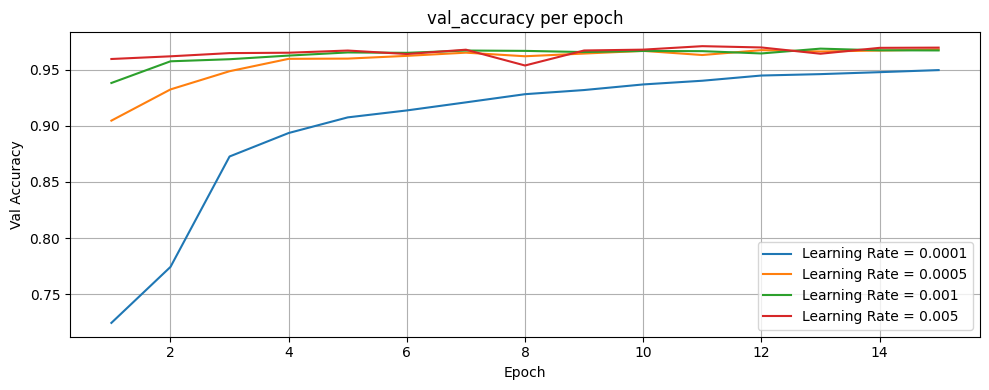

In [ ]:
# Learning rate

histories = {} # Cria/Limpa o dicionário de resultados

for lr in lr_classes:
  history = explore(learning_rate=lr) # Define e treina o modelo
  histories[lr] = history.history['val_accuracy'] # Armazena os resultados do treino

view('Learning Rate', histories) # Plota os resultados para comparação

No que tange aos 4 valores de *Learning Rate* testados, é possível notar que o valor `0.0001` teve uma curva de acurácia inferior aos três outros valores, os quais tiveram desempenhos parecidos. Nesse caso, os valores `0.001` ou `0.005` são os ideais.

### 4.3. Variação das *Funções de Ativação*

A *Função de Ativação* é uma função matemática aplicada em uma camada de neurônios, de forma a introduzir não-linearidades na rede. Estão sendo testadas as seguintes combinações, considerando uma rede que possui 2 camadas:

- `('relu', 'relu')`;
- `('relu', 'sigmoid')`;
- `('tanh', 'relu')`;
- `('tanh', 'sigmoid')`;
- `('tanh', 'tanh')`;

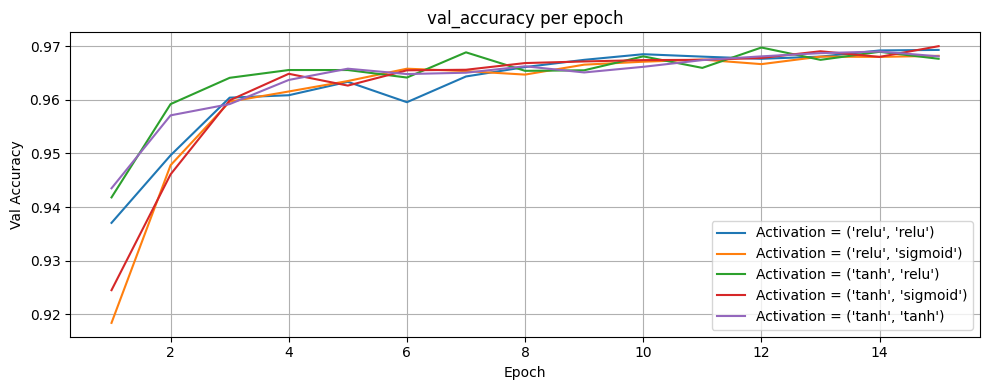

In [ ]:
# Funções de ativação

histories = {} # Cria/Limpa o dicionário de resultados

for act in act_classes:
  history = explore(activations=act) # Define e treina o modelo
  histories[act] = history.history['val_accuracy'] # Armazena os resultados do treino

view('Activation', histories) # Plota os resultados para comparação

A avaliação das diferentes combinações de funções de ativação trouxeram resultados mistos e sensíveis. Enquanto modelos com `sigmoid` apresentaram desempenho inicial inferior, modelos com `tanh` se sairam um pouco melhor. Uma combinação estável é `('tanh', 'relu')`.

### 4.4. Variação da *Largura* e *Profundidade*

A *Largura* corresponde ao número de neurônios em uma camada da rede, enquanto a *Profundidade* corresponde à quantidade de camadas existentes na rede. As combinações de *Largura* e *Profundidade* a serem testadas estão listadas a seguir:

- `(64)`;
- `(64, 32)`;
- `(128, 64)`;
- `(128, 64, 32)`;
- `(256, 128, 64)`.

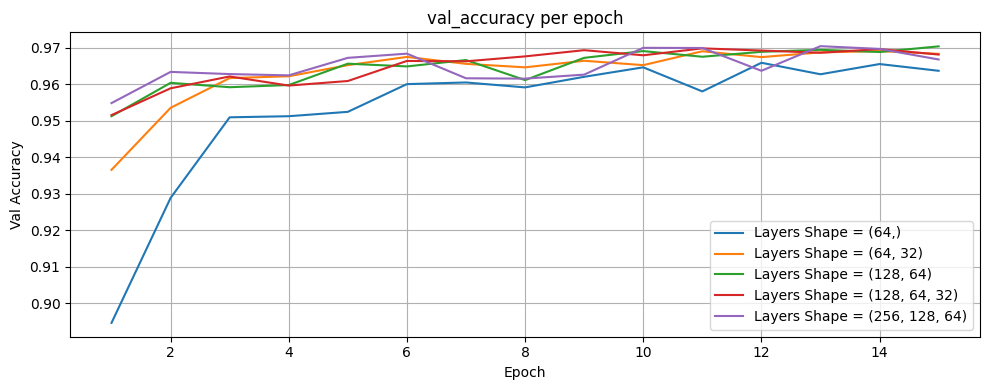

In [ ]:
# Largura e profundidade da rede

histories = {} # Cria/Limpa o dicionário de resultados

for layer in layer_classes:
  history = explore(layer_sizes = layer[0],  # Define e treina o modelo
                    activations = layer[1])
  histories[layer[0]] = history.history['val_accuracy'] # Armazena os resultados do treino

view('Layers Shape', histories) # Plota os resultados para comparação

Assim como na análise das funções de ativação, os resultados dos testes com diferentes combinações de largura e profundidade foram mistos. O modelo com uma camada teve um desempenho inferior aos outros, enquanto todos os outros apresentaram comportamento parecido após a época `8`. Bons resultados partiram de combinações como `(128, 64)` e `(256, 128, 64)`.

### 4.5. Variação do *Otimizador*

O *Otimizador* é o algoritmo que ajusta os pesos da rede para minimizar a função de perda. Os otimizadores testados são:

- `Adam`;
- `SGD`;
- `RMSprop`;
- `Adagrad`.

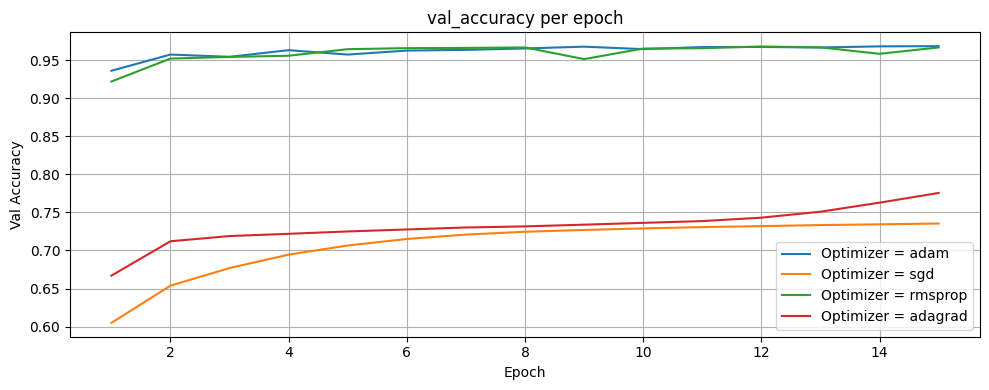

In [ ]:
# Otimizador

histories = {} # Cria/Limpa o dicionário de resultados

for opt in opt_classes.keys():
  history = explore(optimizer=opt_classes[opt]) # Define e treina o modelo
  histories[opt] = history.history['val_accuracy'] # Armazena os resultados do treino

view('Optimizer', histories) # Plota os resultados para comparação

Já na análise dos otimizadores, é clara a diferença entre o desempenho dos modelos. Enquando `sgd` e `adagrad` trouxeram resultados por volta de 73%, `rmsprop` e `rmsprop` trouxeram resultados por volta de 95%, com o `adam` se saindo levemente melhor.

### 4.6. Variação do *Regularizador*

O *Regularizador* é um algoritmo que penaliza o modelo para reduzir o risco de *overfitting*. Os parâmetros testados são:

- `No Regularizer`;
- `L1`;
- `L2`;
- `L1 + L2`.

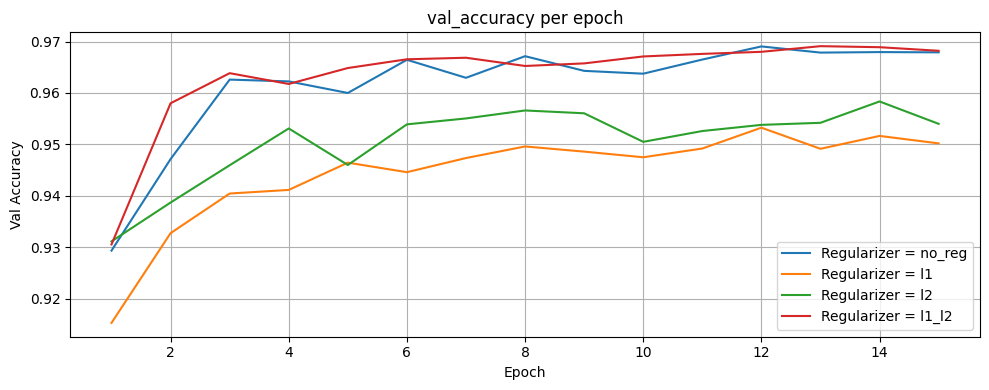

In [ ]:
# Regularizador

histories = {} # Cria/Limpa o dicionário de resultados

for reg in reg_classes.keys():
  history = explore(regularizer=reg_classes[reg]) # Define e treina o modelo
  histories[reg] = history.history['val_accuracy'] # Armazena os resultados do treino

view('Regularizer', histories) # Plota os resultados para comparação

Agora no escopo dos regularizadores, nota-se um desempenho inferior para o uso de apenas `l1` ou apenas `l2`, e um desempenho superior para o treino sem regularizadores ou com ambos. Aqui, ambas essas opções trazem resultados satisfatórios para a acurácia de validação.

### 4.7. Teste Final: *Underfitting* e *Overfitting*

Após o teste de efeitos com múltiplos parâmetros, será definido um novo modelo, com alguns dos parâmetros "ótimos" encontrados, a fim de se analizar a ocorrência de *underfitting* ou *overfitting* com base no número de épocas. Assim, inicia-se o treinamento, com `30` épocas:

In [ ]:
# Cria o modelo com os parâmetros definidos
model.build(layer_sizes = (128, 64), # Largura e profundidade da rede
            activations = ('tanh', 'relu'), # Funções de Ativação para cada camada
            regularizer = l1_l2) # Regularizador

# Compila o modelo com os parâmetros definidos
model.compile(optimizer = Adam, # Otimizador
              loss = 'sparse_categorical_crossentropy', # Função de Perda
              lr = 0.005) # Learning Rate ou Taxa de Aprendizado

# Treina o modelo com os parâmetros definidos
history = model.fit(epochs = 30, # Número de épocas
                    batch_size = 128) # Tamanho dos batches

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8967 - loss: 0.2902 - val_accuracy: 0.9520 - val_loss: 0.1444
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9497 - loss: 0.1531 - val_accuracy: 0.9523 - val_loss: 0.1386
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9558 - loss: 0.1406 - val_accuracy: 0.9496 - val_loss: 0.1490
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9550 - loss: 0.1423 - val_accuracy: 0.9656 - val_loss: 0.1124
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9628 - loss: 0.1234 - val_accuracy: 0.9637 - val_loss: 0.1172
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9575 - loss: 0.1350 - val_accuracy: 0.9635 - val_loss: 0.1155
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9612 - loss: 0.1234 - val_accuracy: 0.9667 - val_loss: 0.1060
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9618 - loss: 0.1256 - val_accuracy: 0.

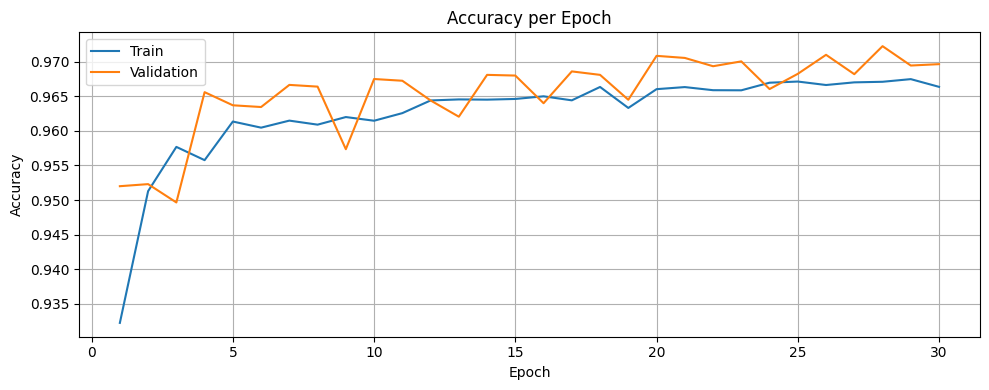

In [ ]:
# Visualização da comparação entre as acurácias de Treino e de Validação

plt.figure(figsize=(10, 4))
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Train') # Gráfico de Treino
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Validation') # Gráfico de Validação
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

O *Underfitting*, de forma resumida, ocorre quando a rede é incapaz de aprender de forma satisfatória os padrões do *Dataset*, o que resulta em um baixo desempenho. Por outro lado, o *Overfitting* ocorre quando a rede se especializa nos padrões dos dados de treino, perdendo a capacidade de generalização. Uma forma comum de se identificar a ocorrência desses fenômenos é na comparação dos valores de acurácia de treino e de validação ao longo das épocas, observando como é a evolução destes.

Analisando os padrões do gráfico, são perceptíveis os seguintes pontos:
- A rede não parece sofrer com *Underfitting*, uma vez que os valores das acurácias são satisfatórios e apresentam certa evolução ao longo das primeiras épocas, como é esperado em um processo de treinamento;
- O *Overfitting*, por sua vez, mostra sinais de ocorrência. Após a época `15`, é perceptível que a acurácia de treino inicia uma progressão lenta, enquanto a acurácia de validação parece estagnada em uma faixa de valores. Esses sinais estão costumente associados ao *Overfitting*. Por isso, não é incorreto assumir que a rede assume essa característica depois das épocas `15` ou `20`.

## **5. Conclusão**

Após um longo *Pipeline* voltado para a investigação do *Dataset*, além da construção e análise de uma Rede Neural e de seus parâmetros, foi perceptível que, para o conjunto de dados trabalhado, o modelo atingiu um desempenho satisfatório logo nos primeiros testes, com uma acurácia de validação de, aproximadamente, 97%, apresentando um *Overfitting* discreto após a época `20`.

Nesse sentido, foram trabalhadas também comparações entre os efeitos de diferentes valores para parâmetros utilizados no modelo, como *Função de Ativação* e *Largura/Profundidade* da rede. Daqueles trabalhados, parâmetros como *Regularizador*, *Otimizador* e *Learning Rate* trouxeram diferenças claras nos testes comparativos, evidenciando o seu grande impacto no treinamento do modelo com o *Dataset*.

## **6. Bibliografia**

- 1. **Stellar Classification Dataset - SDSS17**. Kaggle. Disponível em: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17. Acesso em: 09 jun. 2025.
- 2. **O que é uma rede neural?** Amazon Web Services. Disponível em: https://aws.amazon.com/what-is/neural-network/. Acesso em: 09 jun. 2025.
- 3. MUCCI, T. **Overfitting vs. underfitting: encontrando o equilíbrio** International Business Machines Corporation. Disponível em: https://www.ibm.com/br-pt/think/topics/overfitting-vs-underfitting. Acesso em: 09 jun. 2025.
